In [1]:
import time
import random
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import load_model


Using TensorFlow backend.


In [2]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Percentage Error')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
#   plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
#            label = 'Val Error')
#   plt.ylim([0,max(hist['val_mean_absolute_error'].max(), hist['mean_absolute_error'].max())])
  plt.legend()
    
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
#   plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
#            label = 'Val Error')
#   plt.ylim([0,max(hist['val_mean_absolute_error'].max(), hist['mean_absolute_error'].max())])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
#   plt.plot(hist['epoch'], hist['val_mean_squared_error'],
#            label = 'Val Error')
#   plt.ylim([0,max(hist['val_mean_squared_error'].max(), hist['mean_squared_error'].max())])
  plt.legend()
  plt.show()


In [3]:
# X_COLS = [
#     'weight', 'intra_error', 'frame_avg_wavelet_energy', 
#     'coded_error', 'sr_coded_error', 'tr_coded_error',
#     'pcnt_inter', 'pcnt_motion', 'pcnt_second_ref', 
#     'pcnt_third_ref', 'pcnt_neutral', 'inactive_zone_rows',
#     'inactive_zone_cols', 'MVr', 'mvr_abs', 
#     'MVc', 'mvc_abs', 'MVrv', 
#     'MVcv', 'mv_in_out_count', 'new_mv_count', 
#     'raw_error_stdev',
#     'cq_value',
# ]

X_COLS = [
    'weight', 'frame_avg_wavelet_energy',
    'MVr', 'MVc',
    'pcnt_inter', 'pcnt_motion', 'pcnt_second_ref', 
    'pcnt_third_ref', 'pcnt_neutral',
    'mv_in_out_count',
    'vmaf',
#     'cq_value',
#     'psnr'
]


X_COLS = X_COLS + [f'nxt_{s}' for s in X_COLS]

Y_COLS = [
    'cq_value'
#     'ms_ssim', 'psnr', 'ssim', 'vmaf'
#     'vmaf'
#     'ms_ssim', 'psnr', 'ssim'
]

# Y_COLS = ['vmaf']

display(f'{len(X_COLS)=}, {len(Y_COLS)=}')

'len(X_COLS)=22, len(Y_COLS)=1'

In [4]:
def load_data():
    csvs = [f for f in glob.glob(f"dataset/csv/*.csv")]
#     csvs = [csvs[3]]  # only 1 cq level
    csvs.sort()
    print(csvs)
    dfs = [pd.read_csv(f) for f in csvs]  # .diff().dropna()
#     for df in dfs:
#         df[X_COLS] = df[X_COLS].shift(-1) - df[X_COLS]
    dfs = [pd.concat([df, df.shift(1).add_prefix('nxt_')], axis=1) for df in dfs]
    return pd.concat(dfs, axis=0, ignore_index=True).dropna()

In [5]:
df = load_data()
display(df)
display(df.describe())

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df.mean())

['dataset/csv/s1_30.csv', 'dataset/csv/s1_35.csv', 'dataset/csv/s1_40.csv', 'dataset/csv/s1_45.csv', 'dataset/csv/s1_50.csv', 'dataset/csv/s1_55.csv', 'dataset/csv/s1_60.csv']


,Unnamed: 0,frame,weight,intra_error,frame_avg_wavelet_energy,coded_error,sr_coded_error,tr_coded_error,pcnt_inter,pcnt_motion,...,nxt_motion2,nxt_ms_ssim,nxt_psnr,nxt_ssim,nxt_vif_scale0,nxt_vif_scale1,nxt_vif_scale2,nxt_vif_scale3,nxt_vmaf,nxt_cq_value
1,1,1.0,1.160618,938272.543665,29342160.0,332834.543665,2.052255e+06,756068.543665,0.865931,0.610662,...,0.00000,0.99995,60.19751,0.99984,1.00000,1.00000,1.00000,1.00000,97.42799,30.0
2,2,2.0,1.181501,853136.543665,27864466.0,327928.543665,5.730245e+05,668055.543665,0.761152,0.509804,...,0.27556,0.99674,45.46700,0.99889,0.65612,0.99607,0.99808,0.99894,96.89101,30.0
3,3,3.0,1.202625,767867.543665,26153351.0,256955.543665,4.732775e+05,571896.543665,0.669118,0.423039,...,0.26269,0.99672,46.05847,0.99873,0.67791,0.99701,0.99854,0.99916,97.39241,30.0
4,4,4.0,1.226040,710757.543665,21443737.0,278205.543665,4.158365e+05,482624.543665,0.926838,0.501593,...,0.26269,0.99671,46.08210,0.99873,0.67857,0.99742,0.99876,0.99931,97.21205,30.0
5,5,5.0,1.248711,544988.543665,17787360.0,165585.543665,3.014335e+05,305028.543665,0.731985,0.430392,...,0.26794,0.99672,46.08080,0.99875,0.67749,0.99738,0.99875,0.99931,97.44133,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189191,27023,190.0,1.229014,364817.543665,11475882.0,95449.543665,9.254554e+04,34609.543665,0.465196,0.204167,...,0.00630,0.99938,54.21875,0.99957,0.99717,0.99956,0.99997,1.00000,85.04760,60.0
189192,27024,191.0,1.233539,362240.543665,11441041.0,26095.543665,8.458354e+04,29593.543665,0.998162,0.345221,...,0.01184,0.99948,54.28501,0.99966,0.99803,0.99983,1.00000,1.00000,86.83407,60.0
189193,27025,192.0,1.235129,362000.543665,11412955.0,26015.543665,2.823354e+04,26296.543665,0.996814,0.486152,...,0.00378,0.99951,54.36237,0.99970,0.99884,1.00000,1.00000,1.00000,88.16614,60.0
189194,27026,193.0,1.233220,362200.543665,11491761.0,26125.543665,2.910254e+04,26420.543665,0.997181,0.493382,...,0.00250,0.99953,54.37609,0.99972,0.99922,1.00000,1.00000,1.00000,88.98662,60.0


,Unnamed: 0,frame,weight,intra_error,frame_avg_wavelet_energy,coded_error,sr_coded_error,tr_coded_error,pcnt_inter,pcnt_motion,...,nxt_motion2,nxt_ms_ssim,nxt_psnr,nxt_ssim,nxt_vif_scale0,nxt_vif_scale1,nxt_vif_scale2,nxt_vif_scale3,nxt_vmaf,nxt_cq_value
count,189189.000000,189189.000000,189189.000000,1.891890e+05,1.891890e+05,1.891890e+05,1.891890e+05,1.891890e+05,189189.000000,189189.000000,...,189189.000000,189189.000000,189189.000000,189189.000000,189189.000000,189189.000000,189189.000000,189189.000000,189189.000000,189189.000000
mean,13514.000000,164.042624,1.200821,5.334955e+05,1.694160e+07,6.470673e+04,8.807678e+04,1.399045e+05,0.972476,0.417924,...,1.899240,0.992680,45.292940,0.993688,0.734335,0.933618,0.960154,0.973113,90.276834,45.000000
std,7802.043477,202.996172,0.058471,6.875447e+05,7.887933e+06,1.210712e+05,2.986183e+05,6.883874e+05,0.113905,0.267945,...,2.850154,0.006177,3.849249,0.005999,0.134162,0.055553,0.038480,0.028394,6.904509,10.000026
min,1.000000,0.000000,1.031669,5.148654e+04,0.000000e+00,1.806654e+04,1.806654e+04,1.806654e+04,0.000000,0.000000,...,0.000000,0.898090,29.165670,0.876950,0.148840,0.428780,0.501370,0.569860,20.039230,30.000000
25%,6757.000000,33.000000,1.173908,1.301085e+05,1.271459e+07,3.333654e+04,3.755854e+04,4.126654e+04,0.991789,0.159926,...,0.567750,0.990530,43.203020,0.991910,0.649780,0.910080,0.946750,0.964700,86.979060,35.000000
50%,13514.000000,85.000000,1.190660,2.773245e+05,1.576769e+07,4.071754e+04,4.657954e+04,5.930854e+04,0.998529,0.450123,...,1.015520,0.993880,45.059830,0.995110,0.742440,0.947930,0.971590,0.982030,91.923140,45.000000
75%,20271.000000,209.000000,1.211848,5.789695e+05,1.877815e+07,5.352354e+04,7.111654e+04,1.084425e+05,0.999877,0.632598,...,2.026370,0.996530,46.909150,0.997370,0.828970,0.971380,0.985280,0.990980,95.147570,55.000000
max,27027.000000,1156.000000,1.499939,4.001773e+06,8.457172e+07,3.633678e+06,3.749412e+07,4.882172e+07,1.000000,0.983578,...,69.762050,0.999960,63.222640,0.999950,1.003720,1.023040,1.025310,1.033420,100.000000,60.000000


Unnamed: 0                      1.351400e+04
frame                           1.640426e+02
weight                          1.200821e+00
intra_error                     5.334955e+05
frame_avg_wavelet_energy        1.694160e+07
coded_error                     6.470673e+04
sr_coded_error                  8.807678e+04
tr_coded_error                  1.399045e+05
pcnt_inter                      9.724755e-01
pcnt_motion                     4.179238e-01
pcnt_second_ref                 1.683899e-01
pcnt_third_ref                  1.706898e-01
pcnt_neutral                    5.463165e-01
intra_skip_pct                  2.697365e-02
inactive_zone_rows              1.177415e+00
inactive_zone_cols              0.000000e+00
MVr                             1.010128e+00
mvr_abs                         7.069395e+01
MVc                            -1.041517e+01
mvc_abs                         9.121411e+01
MVrv                            4.378070e+04
MVcv                            7.929558e+04
mv_in_out_

In [6]:
def build_model():
    model = keras.Sequential([
        layers.Dense(8, activation=tf.nn.selu, input_shape=[len(X_COLS)], kernel_initializer='lecun_normal'),
        layers.Dense(8, activation=tf.nn.selu, kernel_initializer='lecun_normal'),
        layers.Dense(len(Y_COLS))
    ])
    
    optimizer = tf.keras.optimizers.Nadam(learning_rate=0.003)
    
    # loss: mean_squared_error or mean_absolute_error
    model.compile(loss='mean_absolute_error',
                  optimizer=optimizer,
                  metrics=['mean_absolute_percentage_error', 'mean_absolute_error', 'mean_squared_error'])
    return model


In [7]:
x_train = df[X_COLS]
y_train = df[Y_COLS]
# y_train['ssim'] *= 100
# y_train['ms_ssim'] *= 100

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(x_train.mean())
    display(x_train.std())
    display(y_train.mean())
    display(y_train.std())

display(x_train.describe())

x_train = (x_train - x_train.mean()) / x_train.std()
y_train = (y_train - y_train.mean()) / y_train.std()

display(x_train)
display(y_train)

weight                          1.200821e+00
frame_avg_wavelet_energy        1.694160e+07
MVr                             1.010128e+00
MVc                            -1.041517e+01
pcnt_inter                      9.724755e-01
pcnt_motion                     4.179238e-01
pcnt_second_ref                 1.683899e-01
pcnt_third_ref                  1.706898e-01
pcnt_neutral                    5.463165e-01
mv_in_out_count                -1.086130e-02
vmaf                            9.027662e+01
nxt_weight                      1.200817e+00
nxt_frame_avg_wavelet_energy    1.694225e+07
nxt_MVr                         1.012099e+00
nxt_MVc                        -1.041595e+01
nxt_pcnt_inter                  9.724387e-01
nxt_pcnt_motion                 4.179052e-01
nxt_pcnt_second_ref             1.683853e-01
nxt_pcnt_third_ref              1.706898e-01
nxt_pcnt_neutral                5.462896e-01
nxt_mv_in_out_count            -1.086159e-02
nxt_vmaf                        9.027683e+01
dtype: flo

weight                          5.847092e-02
frame_avg_wavelet_energy        7.887933e+06
MVr                             4.513486e+01
MVc                             1.146930e+02
pcnt_inter                      1.139054e-01
pcnt_motion                     2.679447e-01
pcnt_second_ref                 1.136325e-01
pcnt_third_ref                  1.678372e-01
pcnt_neutral                    1.904098e-01
mv_in_out_count                 1.689994e-01
vmaf                            6.904385e+00
nxt_weight                      5.847152e-02
nxt_frame_avg_wavelet_energy    7.888192e+06
nxt_MVr                         4.513365e+01
nxt_MVc                         1.146929e+02
nxt_pcnt_inter                  1.140588e-01
nxt_pcnt_motion                 2.679563e-01
nxt_pcnt_second_ref             1.136368e-01
nxt_pcnt_third_ref              1.678372e-01
nxt_pcnt_neutral                1.904357e-01
nxt_mv_in_out_count             1.689993e-01
nxt_vmaf                        6.904509e+00
dtype: flo

cq_value    45.0
dtype: float64

cq_value    10.000026
dtype: float64

,weight,frame_avg_wavelet_energy,MVr,MVc,pcnt_inter,pcnt_motion,pcnt_second_ref,pcnt_third_ref,pcnt_neutral,mv_in_out_count,...,nxt_frame_avg_wavelet_energy,nxt_MVr,nxt_MVc,nxt_pcnt_inter,nxt_pcnt_motion,nxt_pcnt_second_ref,nxt_pcnt_third_ref,nxt_pcnt_neutral,nxt_mv_in_out_count,nxt_vmaf
count,189189.000000,1.891890e+05,189189.000000,189189.000000,189189.000000,189189.000000,189189.000000,189189.000000,189189.000000,189189.000000,...,1.891890e+05,189189.000000,189189.000000,189189.000000,189189.000000,189189.000000,189189.000000,189189.000000,189189.000000,189189.000000
mean,1.200821,1.694160e+07,1.010128,-10.415171,0.972476,0.417924,0.168390,0.170690,0.546316,-0.010861,...,1.694225e+07,1.012099,-10.415948,0.972439,0.417905,0.168385,0.170690,0.546290,-0.010862,90.276834
std,0.058471,7.887933e+06,45.134860,114.693025,0.113905,0.267945,0.113632,0.167837,0.190410,0.168999,...,7.888192e+06,45.133653,114.692883,0.114059,0.267956,0.113637,0.167837,0.190436,0.168999,6.904509
min,1.031669,0.000000e+00,-1032.000000,-7600.793388,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,...,0.000000e+00,-1032.000000,-7600.793388,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,20.039230
25%,1.173908,1.271459e+07,-5.991111,-12.766730,0.991789,0.159926,0.068995,0.031618,0.428431,-0.085851,...,1.271540e+07,-5.990295,-12.766730,0.991789,0.159681,0.068873,0.031618,0.428431,-0.085851,86.979060
50%,1.190660,1.576769e+07,0.052805,-0.615385,0.998529,0.450123,0.175490,0.126348,0.553019,0.000000,...,1.576776e+07,0.052805,-0.615385,0.998529,0.450123,0.175490,0.126348,0.553019,0.000000,91.923140
75%,1.211848,1.877815e+07,7.677408,7.941748,0.999877,0.632598,0.246569,0.263358,0.696324,0.075717,...,1.877861e+07,7.677408,7.935437,0.999877,0.632598,0.246569,0.263358,0.696324,0.075717,95.147570
max,1.499939,8.457172e+07,1107.339806,1162.220846,1.000000,0.983578,0.889216,0.999877,0.999877,1.000000,...,8.457172e+07,1107.339806,1162.220846,1.000000,0.983578,0.889216,0.999877,0.999877,1.000000,100.000000


,weight,frame_avg_wavelet_energy,MVr,MVc,pcnt_inter,pcnt_motion,pcnt_second_ref,pcnt_third_ref,pcnt_neutral,mv_in_out_count,...,nxt_frame_avg_wavelet_energy,nxt_MVr,nxt_MVc,nxt_pcnt_inter,nxt_pcnt_motion,nxt_pcnt_second_ref,nxt_pcnt_third_ref,nxt_pcnt_neutral,nxt_mv_in_out_count,nxt_vmaf
1,-0.687564,1.572093,11.452407,-0.506326,-0.935374,0.719320,-1.481882,-0.926456,-0.427653,0.169953,...,1.512590,-0.022424,0.090816,-8.525764,-1.559602,-1.481785,-1.016996,-2.868631,0.064270,1.035723
2,-0.330423,1.384757,11.733287,-0.206104,-1.855254,0.342907,-0.343019,-0.945440,-0.672725,-0.235858,...,1.571958,11.452669,-0.506320,-0.933793,0.719358,-1.481785,-0.926456,-0.427453,0.169955,0.957950
3,0.030853,1.167828,10.757879,-0.581831,-2.663243,0.019091,-0.578125,-0.905281,-0.960289,-0.814224,...,1.384629,11.733557,-0.206097,-1.852436,0.342962,-0.342965,-0.945440,-0.672493,-0.235856,1.030570
4,0.431316,0.570763,10.403729,-1.991133,-0.400659,0.312263,-1.129223,-0.868042,0.425321,-0.752543,...,1.167708,10.758123,-0.581825,-2.659338,0.019160,-0.578063,-0.905281,-0.960017,-0.814222,1.004447
5,0.819041,0.107222,9.203426,-2.684808,-2.111315,0.046533,-1.241384,-0.843217,-0.687749,-1.464730,...,0.570661,10.403964,-1.991129,-0.399798,0.312320,-1.129139,-0.868042,0.425404,-0.752541,1.037655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189191,0.482178,-0.692921,8.244907,-5.711788,-4.453514,-0.797766,-1.134615,2.950727,-0.742488,1.142218,...,-0.599545,-1.905486,-0.754047,-0.930569,0.603650,-0.144535,-0.613945,0.553932,0.491483,-0.757365
189192,0.559558,-0.697338,-1.011614,0.358598,0.225505,-0.271337,-1.430115,0.159301,0.301068,-0.145784,...,-0.692981,8.245084,-5.711788,-4.447201,-0.797662,-1.134531,2.950727,-0.742246,1.142220,-0.498625
189193,0.586761,-0.700899,-1.484542,0.290832,0.213670,0.254635,-0.437925,-1.016996,0.821914,0.006842,...,-0.697398,-1.011684,0.358605,0.225525,-0.271255,-1.430020,0.159301,0.301168,-0.145783,-0.305698
189194,0.554113,-0.690908,-1.310434,0.304603,0.216898,0.281620,-0.330078,-1.016996,0.891268,-0.062130,...,-0.700959,-1.484625,0.290839,0.213706,0.254694,-0.437867,-1.016996,0.821943,0.006843,-0.186865


,cq_value
1,-1.499996
2,-1.499996
3,-1.499996
4,-1.499996
5,-1.499996
...,...
189191,1.499996
189192,1.499996
189193,1.499996
189194,1.499996


In [8]:
dataset = tf.data.Dataset.from_tensor_slices((x_train.values, y_train.values))
train_dataset = dataset.shuffle(len(x_train)).batch(2048)

In [9]:
model = build_model()
display(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 184       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 265
Trainable params: 265
Non-trainable params: 0
_________________________________________________________________


None

In [10]:
# model.fit(train_dataset, epochs=10)
history = model.fit(train_dataset, epochs=100)  # callbacks=[]

Epoch 1/100
93/93 [==============================] - 0s 3ms/step - loss: 0.6728 - mean_absolute_percentage_error: 62584232.0000 - mean_absolute_error: 0.6728 - mean_squared_error: 0.7064
Epoch 2/100
93/93 [==============================] - 0s 3ms/step - loss: 0.5963 - mean_absolute_percentage_error: 72604600.0000 - mean_absolute_error: 0.5963 - mean_squared_error: 0.5728
Epoch 3/100
93/93 [==============================] - 0s 3ms/step - loss: 0.5896 - mean_absolute_percentage_error: 73855120.0000 - mean_absolute_error: 0.5896 - mean_squared_error: 0.5652
Epoch 4/100
93/93 [==============================] - 0s 3ms/step - loss: 0.5857 - mean_absolute_percentage_error: 73997256.0000 - mean_absolute_error: 0.5857 - mean_squared_error: 0.5595
Epoch 5/100
93/93 [==============================] - 0s 3ms/step - loss: 0.5836 - mean_absolute_percentage_error: 73585808.0000 - mean_absolute_error: 0.5836 - mean_squared_error: 0.5560
Epoch 6/100
93/93 [==============================] - 0s 3ms/step 

93/93 [==============================] - 0s 4ms/step - loss: 0.5701 - mean_absolute_percentage_error: 74792624.0000 - mean_absolute_error: 0.5701 - mean_squared_error: 0.5402
Epoch 45/100
93/93 [==============================] - 0s 4ms/step - loss: 0.5701 - mean_absolute_percentage_error: 74888128.0000 - mean_absolute_error: 0.5701 - mean_squared_error: 0.5402
Epoch 46/100
93/93 [==============================] - 0s 4ms/step - loss: 0.5698 - mean_absolute_percentage_error: 74564944.0000 - mean_absolute_error: 0.5698 - mean_squared_error: 0.5395
Epoch 47/100
93/93 [==============================] - 0s 4ms/step - loss: 0.5699 - mean_absolute_percentage_error: 74507184.0000 - mean_absolute_error: 0.5699 - mean_squared_error: 0.5396
Epoch 48/100
93/93 [==============================] - 0s 4ms/step - loss: 0.5697 - mean_absolute_percentage_error: 74545696.0000 - mean_absolute_error: 0.5697 - mean_squared_error: 0.5397
Epoch 49/100
93/93 [==============================] - 0s 4ms/step - loss:

93/93 [==============================] - 0s 4ms/step - loss: 0.5668 - mean_absolute_percentage_error: 73487000.0000 - mean_absolute_error: 0.5668 - mean_squared_error: 0.5344
Epoch 88/100
93/93 [==============================] - 0s 4ms/step - loss: 0.5666 - mean_absolute_percentage_error: 73538904.0000 - mean_absolute_error: 0.5666 - mean_squared_error: 0.5343
Epoch 89/100
93/93 [==============================] - 0s 4ms/step - loss: 0.5666 - mean_absolute_percentage_error: 73393248.0000 - mean_absolute_error: 0.5666 - mean_squared_error: 0.5340
Epoch 90/100
93/93 [==============================] - 0s 4ms/step - loss: 0.5666 - mean_absolute_percentage_error: 73503680.0000 - mean_absolute_error: 0.5666 - mean_squared_error: 0.5342
Epoch 91/100
93/93 [==============================] - 0s 3ms/step - loss: 0.5665 - mean_absolute_percentage_error: 73229480.0000 - mean_absolute_error: 0.5665 - mean_squared_error: 0.5339
Epoch 92/100
93/93 [==============================] - 0s 3ms/step - loss:

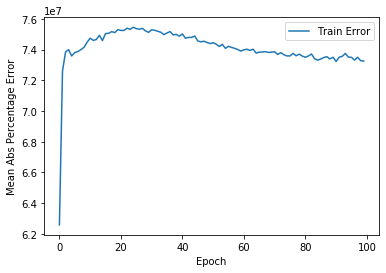

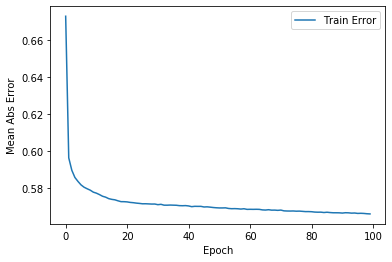

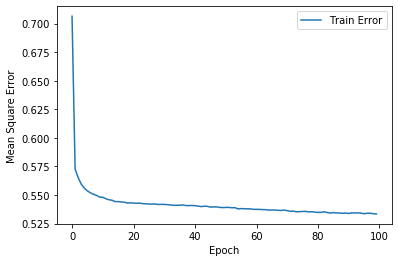

In [11]:
plot_history(history)

In [12]:
def testp(start, end):
    
    tx = df.loc[start:end, X_COLS]
    txf = x_train.loc[start:end, X_COLS]
    ty = df.loc[start:end, Y_COLS]
    tyf = y_train.loc[start:end]
    
    display(tx)
    display(ty)
    display(tyf)
    
    display(model.predict([txf]))

testp(0, 5)
testp(15000, 15000 + 5)
testp(189000, 189000 + 5)

,weight,frame_avg_wavelet_energy,MVr,MVc,pcnt_inter,pcnt_motion,pcnt_second_ref,pcnt_third_ref,pcnt_neutral,mv_in_out_count,...,nxt_frame_avg_wavelet_energy,nxt_MVr,nxt_MVc,nxt_pcnt_inter,nxt_pcnt_motion,nxt_pcnt_second_ref,nxt_pcnt_third_ref,nxt_pcnt_neutral,nxt_mv_in_out_count,nxt_vmaf
1,1.160618,29342160.0,517.912904,-68.487257,0.865931,0.610662,0.000000,0.015196,0.464887,0.017861,...,28873847.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,97.42799
2,1.181501,27864466.0,530.590385,-34.053846,0.761152,0.509804,0.129412,0.012010,0.418223,-0.050721,...,29342160.0,517.912904,-68.487257,0.865931,0.610662,0.000000,0.015196,0.464887,0.017861,96.89101
3,1.202625,26153351.0,486.565469,-77.147161,0.669118,0.423039,0.102696,0.018750,0.363468,-0.148465,...,27864466.0,530.590385,-34.053846,0.761152,0.509804,0.129412,0.012010,0.418223,-0.050721,97.39241
4,1.226040,21443737.0,470.580992,-238.784266,0.926838,0.501593,0.040074,0.025000,0.627302,-0.138041,...,26153351.0,486.565469,-77.147161,0.669118,0.423039,0.102696,0.018750,0.363468,-0.148465,97.21205
5,1.248711,17787360.0,416.405467,-318.343964,0.731985,0.430392,0.027328,0.029167,0.415362,-0.258400,...,21443737.0,470.580992,-238.784266,0.926838,0.501593,0.040074,0.025000,0.627302,-0.138041,97.44133


,cq_value
1,30
2,30
3,30
4,30
5,30


,cq_value
1,-1.499996
2,-1.499996
3,-1.499996
4,-1.499996
5,-1.499996


array([[-0.82229364],
       [-0.63912594],
       [-0.75      ],
       [-0.8986464 ],
       [-0.6873371 ]], dtype=float32)

,weight,frame_avg_wavelet_energy,MVr,MVc,pcnt_inter,pcnt_motion,pcnt_second_ref,pcnt_third_ref,pcnt_neutral,mv_in_out_count,...,nxt_frame_avg_wavelet_energy,nxt_MVr,nxt_MVc,nxt_pcnt_inter,nxt_pcnt_motion,nxt_pcnt_second_ref,nxt_pcnt_third_ref,nxt_pcnt_neutral,nxt_mv_in_out_count,nxt_vmaf
15000,1.374907,13161947.0,2.447059,49.317647,1.0,0.010417,0.005270,0.000735,0.668505,-0.076471,...,13453039.0,1.833333,24.750000,1.0,0.011765,0.005515,0.000245,0.669485,-0.067708,95.45193
15001,1.374610,13091232.0,3.428571,116.395604,1.0,0.011152,0.004167,0.000245,0.668260,-0.126374,...,13161947.0,2.447059,49.317647,1.0,0.010417,0.005270,0.000735,0.668505,-0.076471,94.69772
15002,1.374797,13074370.0,6.726115,55.796178,1.0,0.019240,0.008088,0.001225,0.668382,-0.127389,...,13091232.0,3.428571,116.395604,1.0,0.011152,0.004167,0.000245,0.668260,-0.126374,94.77959
15003,1.374241,13237166.0,-1.465649,34.076336,1.0,0.016054,0.005147,0.000735,0.668627,-0.080153,...,13074370.0,6.726115,55.796178,1.0,0.019240,0.008088,0.001225,0.668382,-0.127389,93.94934
15004,1.374755,12977824.0,-2.000000,-188.080000,1.0,0.012255,0.005392,0.000245,0.668505,0.015000,...,13237166.0,-1.465649,34.076336,1.0,0.016054,0.005147,0.000735,0.668627,-0.080153,94.53066
15005,1.374249,12896172.0,-2.256410,137.572650,1.0,0.014338,0.004289,0.000123,0.669363,0.042735,...,12977824.0,-2.000000,-188.080000,1.0,0.012255,0.005392,0.000245,0.668505,0.015000,94.23465


,cq_value
15000,30
15001,30
15002,30
15003,30
15004,30
15005,30


,cq_value
15000,-1.499996
15001,-1.499996
15002,-1.499996
15003,-1.499996
15004,-1.499996
15005,-1.499996


array([[-1.6348906],
       [-1.5794715],
       [-1.5401053],
       [-1.5109259],
       [-1.5584576],
       [-1.4470209]], dtype=float32)

,weight,frame_avg_wavelet_energy,MVr,MVc,pcnt_inter,pcnt_motion,pcnt_second_ref,pcnt_third_ref,pcnt_neutral,mv_in_out_count,...,nxt_frame_avg_wavelet_energy,nxt_MVr,nxt_MVc,nxt_pcnt_inter,nxt_pcnt_motion,nxt_pcnt_second_ref,nxt_pcnt_third_ref,nxt_pcnt_neutral,nxt_mv_in_out_count,nxt_vmaf
189000,1.115962,29479929.0,41.096053,26.364543,0.982108,0.909681,0.203309,0.000000,0.335366,0.095177,...,29910589.0,43.911904,10.007296,0.983211,0.906985,0.225245,0.000000,0.353629,0.088974,92.72776
189001,1.190867,16698958.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,29479929.0,41.096053,26.364543,0.982108,0.909681,0.203309,0.000000,0.335366,0.095177,92.27116
189002,1.192024,16226698.0,9.600000,11.117949,0.999877,0.023897,0.000000,0.203186,0.322020,-0.105128,...,16698958.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,92.10697
189003,1.191925,16208122.0,0.588235,3.490196,0.999877,0.025000,0.043995,0.087010,0.310049,-0.151961,...,16226698.0,9.600000,11.117949,0.999877,0.023897,0.000000,0.203186,0.322020,-0.105128,92.10092
189004,1.192095,16182521.0,3.416058,4.204380,1.000000,0.033578,0.072426,0.076103,0.317214,-0.058394,...,16208122.0,0.588235,3.490196,0.999877,0.025000,0.043995,0.087010,0.310049,-0.151961,92.10144
189005,1.191898,16164110.0,-0.640000,9.706667,0.999877,0.027574,0.060417,0.098897,0.311153,-0.184444,...,16182521.0,3.416058,4.204380,1.000000,0.033578,0.072426,0.076103,0.317214,-0.058394,92.09795


,cq_value
189000,60
189001,60
189002,60
189003,60
189004,60
189005,60


,cq_value
189000,1.499996
189001,1.499996
189002,1.499996
189003,1.499996
189004,1.499996
189005,1.499996


array([[-0.18930149],
       [ 0.00456266],
       [-0.08880462],
       [ 0.31836712],
       [ 0.3220662 ],
       [ 0.35154617]], dtype=float32)

In [13]:
model.save('my_model.h5')